In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
# build a data frame
data_url = 'https://raw.githubusercontent.com/hcimwtc/ML2022/main/abalone.data'
column_headers = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
                  'Viscera weight', 'Shell weight', 'Rings']
df_abalone_original = pd.read_csv(data_url, header = None, names = column_headers, skipinitialspace = True)

'''INSPECTION'''

In [ ]:
# make a copy of data frame for pre-processing procedure (to prevent contamination)
df_abalone = df_abalone_original.copy()
df_abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [ ]:
# inspect numeric data
df_abalone.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
# data 정보 확인
df_abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [ ]:
# inspect categorical data
for col in df_abalone:
    if df_abalone[col].dtype == object:
        print('\"', col, '\"\n', df_abalone[col].value_counts(), '\n', sep='')

"Sex"
M    1528
I    1342
F    1307
Name: Sex, dtype: int64



In [ ]:
# evaluate the correlation between columns
df_abalone.apply(lambda x: x.factorize()[0]).corr(method='kendall')

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Sex,1.000000,-0.032968,-0.043155,-0.076541,-0.006448,-0.075521,-0.050022,0.002579,0.027396
Length,-0.032968,1.000000,0.280203,0.184821,0.085213,0.135902,0.133054,0.106649,0.120604
Diameter,-0.043155,0.280203,1.000000,0.197291,0.059719,0.128202,0.115472,0.101170,0.120761
Height,-0.076541,0.184821,0.197291,1.000000,0.066048,0.111299,0.125064,0.089135,0.126979
Whole weight,-0.006448,0.085213,0.059719,0.066048,1.000000,0.243687,0.191411,0.157473,0.001838
Shucked weight,-0.075521,0.135902,0.128202,0.111299,0.243687,1.000000,0.205974,0.175935,0.010771
Viscera weight,-0.050022,0.133054,0.115472,0.125064,0.191411,0.205974,1.000000,0.127658,0.032993
Shell weight,0.002579,0.106649,0.101170,0.089135,0.157473,0.175935,0.127658,1.000000,-0.015204
Rings,0.027396,0.120604,0.120761,0.126979,0.001838,0.010771,0.032993,-0.015204,1.000000


In [ ]:
# rank the correlation of columns in respect to the target ('income')
df_corr = df_abalone.apply(lambda x: x.factorize()[0]).corr(method='kendall')
df_corr['Rings'].abs().sort_values()

Whole weight      0.001838
Shucked weight    0.010771
Shell weight      0.015204
Sex               0.027396
Viscera weight    0.032993
Length            0.120604
Diameter          0.120761
Height            0.126979
Rings             1.000000
Name: Rings, dtype: float64

In [ ]:
# inspect NAN values in data
df_abalone.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

'''PRE-PROCESSING'''

In [ ]:
lowerBound = df_abalone.Rings.mean() - df_abalone.Rings.std() * 2
lowerBound

3.4853463983966613

In [ ]:
# drop columns that are duplicate or irrelevant (low corr)
df_abalone.drop(columns = ['Whole weight', 'Shucked weight', 'Shell weight', 'Sex'], inplace = True)
# drop rows where the 'Rings' values are outliers
df_abalone.drop(df_abalone[df_abalone.Rings < 3.5].index, inplace = True)

In [ ]:
# inspect the cleaned data frame again
df_abalone.apply(lambda x: x.factorize()[0]).corr(method='kendall')

,Length,Diameter,Height,Viscera weight,Rings
Length,1.000000,0.278142,0.182061,0.135791,0.116096
Diameter,0.278142,1.000000,0.194034,0.119684,0.116152
Height,0.182061,0.194034,1.000000,0.129242,0.121606
Viscera weight,0.135791,0.119684,0.129242,1.000000,0.035977
Rings,0.116096,0.116152,0.121606,0.035977,1.000000


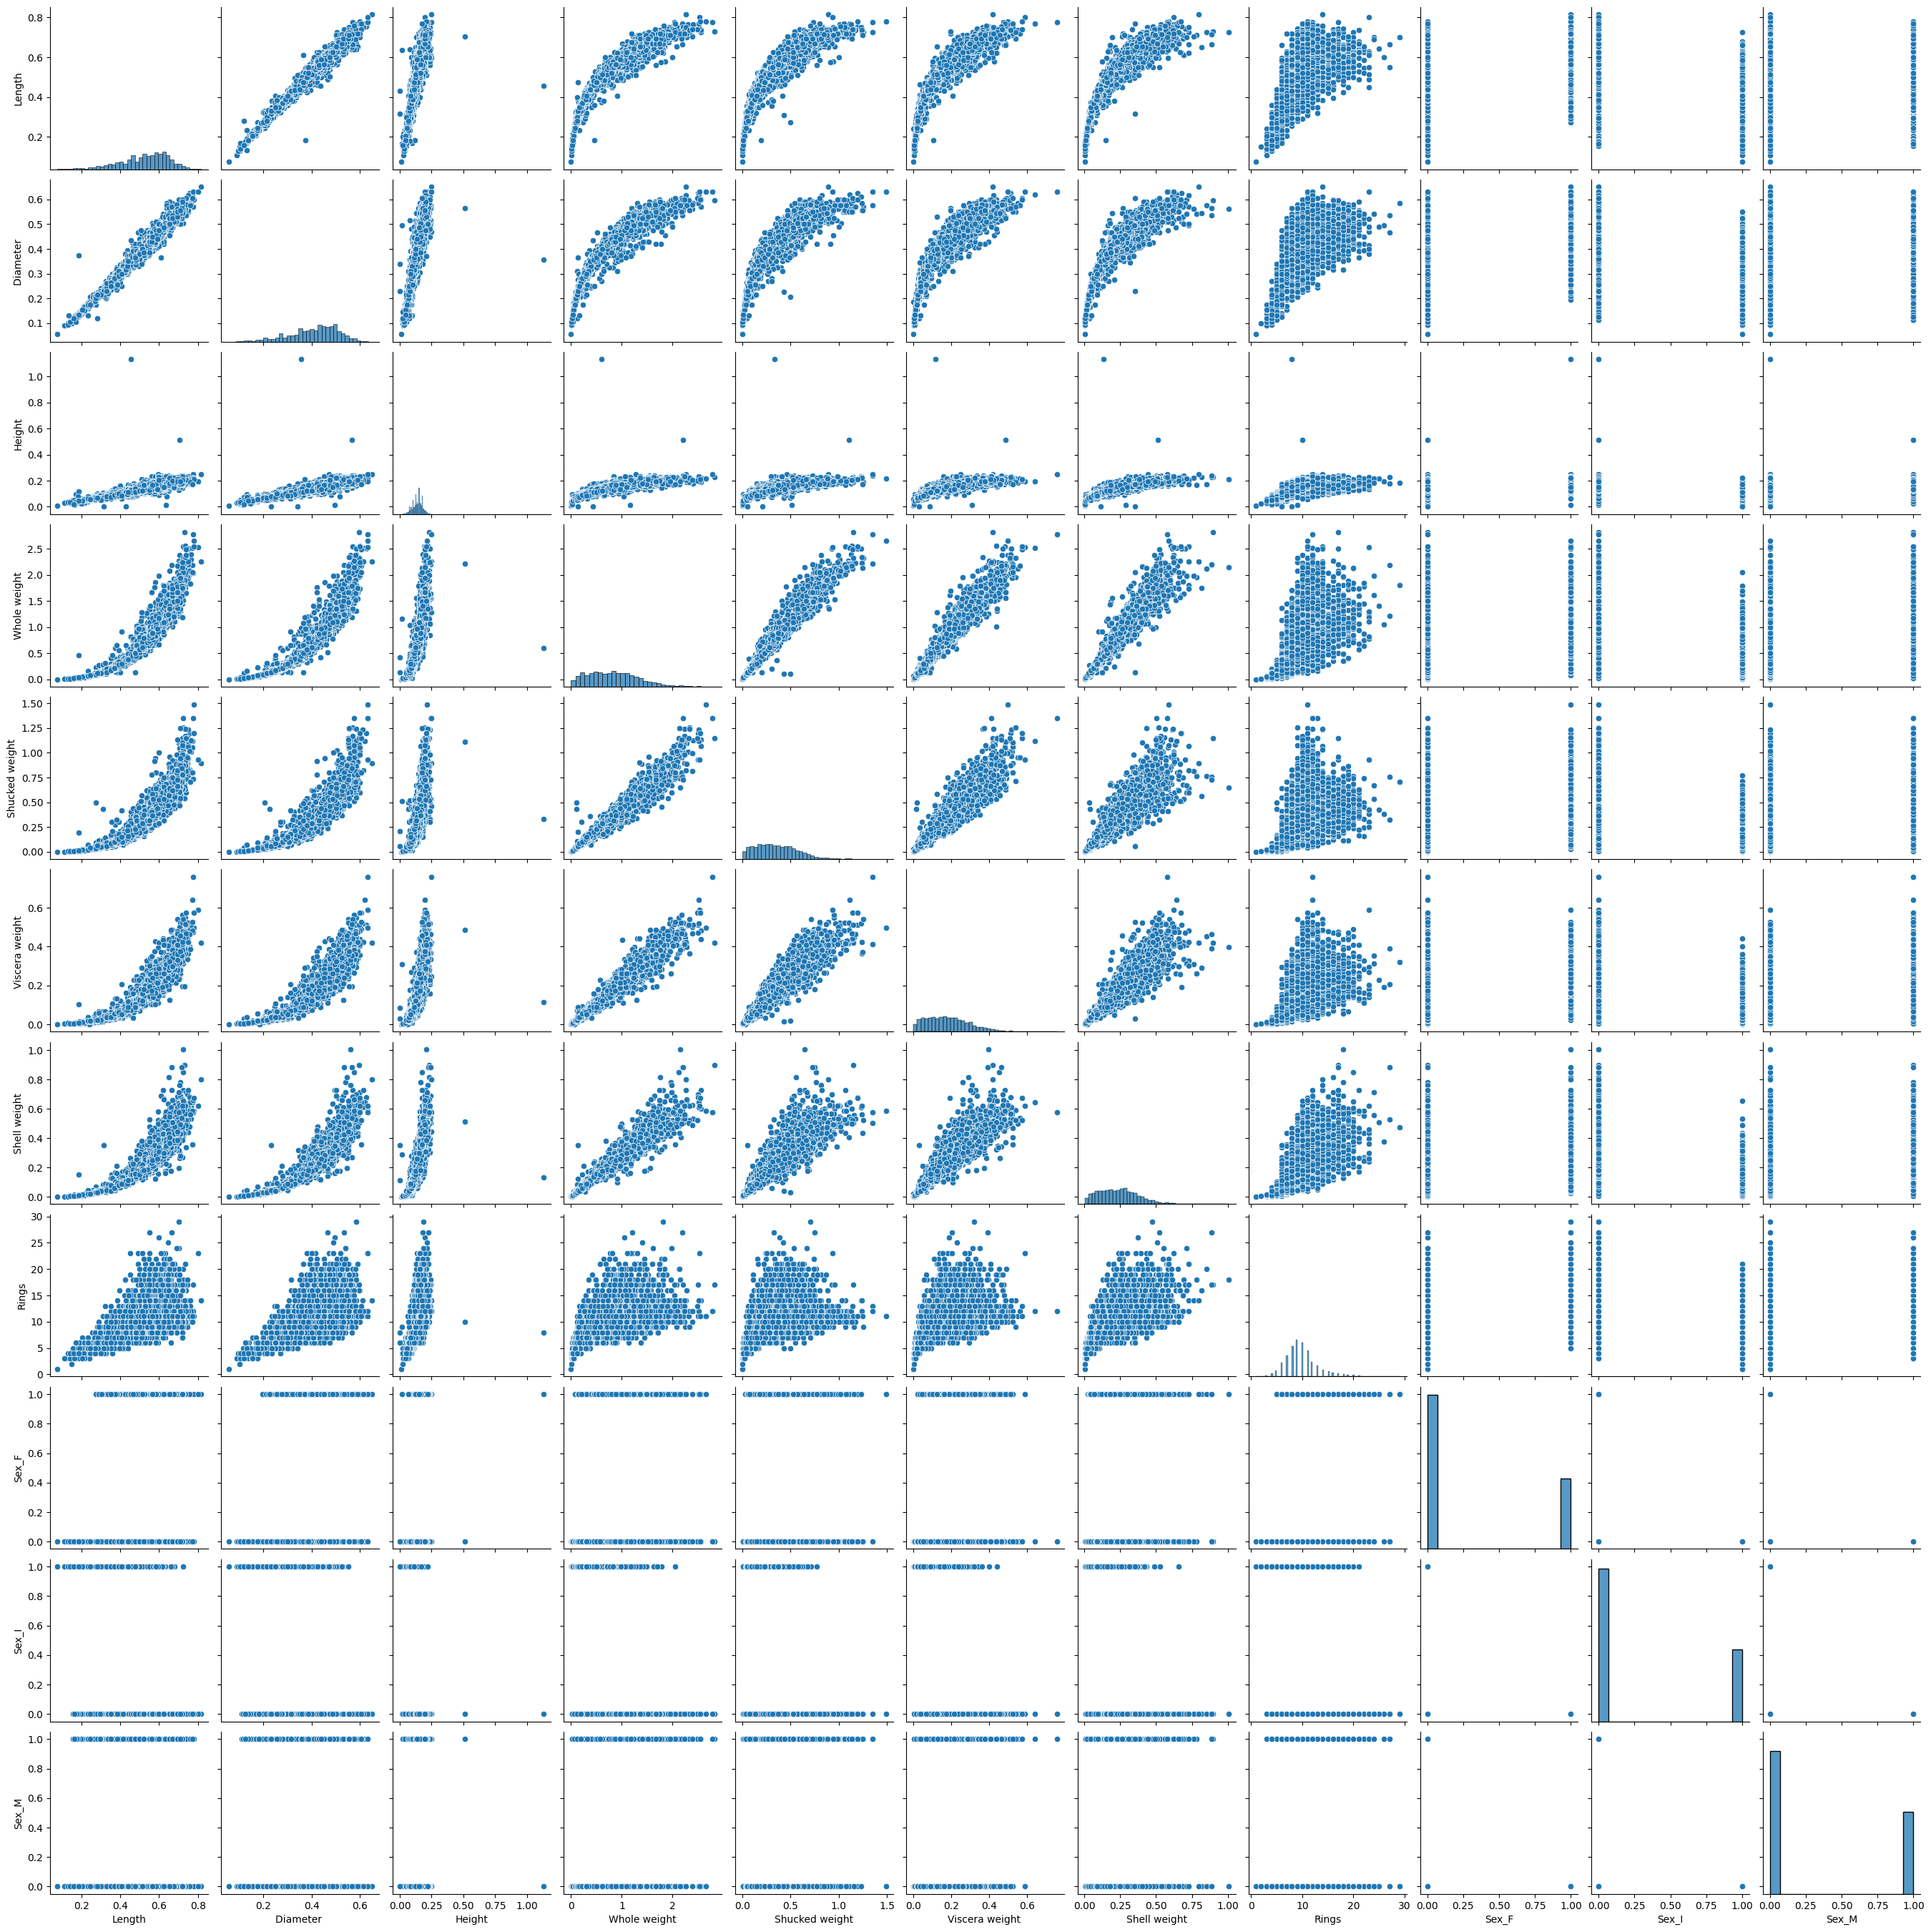

In [ ]:
sns.pairplot(df_abalone)

'''TRANSFORMATION'''

In [ ]:
# define X, y
y = df_abalone['Rings']
X = df_abalone.drop(columns = ['Rings'])

# sort columns into different categories for encoding
numeric_feats = ['Length', 'Diameter', 'Height', 'Viscera weight']

# perform both encoding procedures in one go
cT = make_column_transformer((StandardScaler(), numeric_feats), )

# define new X for train/test splitting
transformed = cT.fit_transform(X)
X = pd.DataFrame(transformed, columns=numeric_feats)

'''MODEL TRAINING & CROSS VALIDATION'''

'''DECISION TREE'''

In [ ]:
# train/test split with KFold (K=2)
kf = KFold(n_splits=2)
DT = DecisionTreeClassifier(random_state=77)
scoreDT = []

In [ ]:
# start training and evaluate score
count = 0
for (train_idx, test_idx) in kf.split(X, y):
    count += 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    DT.fit(X_train, y_train) 
    scoreDT.append(DT.score(X_test, y_test))
    y_pred = DT.predict(X_test)
    f = f1_score(y_true = y_test, y_pred = y_pred, average = 'weighted')
    print('f1 #', count, ': ', f, sep='')
    
print('Best:', max(scoreDT))
print('Worst:', min(scoreDT))
print('Overall:', np.mean(scoreDT))

f1 #1: 0.1739739846927195
f1 #2: 0.16839181631616915
Best: 0.17403846153846153
Worst: 0.16875
Overall: 0.17139423076923077


'''NEURAL NETWORK'''

In [ ]:
def NN_score(hid, lr, mmt):
    scoreNN = []
    NN = MLPClassifier(hidden_layer_sizes = (hid,), learning_rate_init = lr, momentum = mmt, random_state = 77)
    
    count = 0
    for (train_idx, test_idx) in kf.split(X, y):
        count += 1
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        NN.fit(X_train, y_train) 
        scoreNN.append(NN.score(X_test, y_test))
        y_pred = NN.predict(X_test)
        f = f1_score(y_true = y_test, y_pred = y_pred, average = 'weighted')
        print('f1 #', count, ': ', f, sep='')
        
    print('Best:', max(scoreNN))
    print('Worst:', min(scoreNN))
    print('Overall:', np.mean(scoreNN))

In [ ]:
# train NN with hidden-layer = 2, learning-rate = 0.1, momentum = 0.9
NN_score(2, 0.01, 0.9)

f1 #1: 0.20974128642981466
f1 #2: 0.22684980837575697
Best: 0.2673076923076923
Worst: 0.2528846153846154
Overall: 0.2600961538461538


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#Adjusting the parameter with hidden-layer = 53, learning-rate = 0.008, momentum = 0.9
NN_score(5, 0.008, 0.9)

f1 #1: 0.23012488018551824
f1 #2: 0.22774015530279115
Best: 0.2644230769230769
Worst: 0.26009615384615387
Overall: 0.2622596153846154


In [ ]:
#Adjusting the parameter with hidden-layer = 5, learning-rate = 0.007, momentum = 0.9
NN_score(5, 0.007, 0.9)

f1 #1: 0.22994485563962003
f1 #2: 0.22671179595479826
Best: 0.26298076923076924
Worst: 0.26009615384615387
Overall: 0.26153846153846155


# Conclusion

The objective of this dataset is to predict the age of the abalone with the given data. However, the accuracy is not high at all even for ANN. 

Decision Tree classifier give a overall 017 accuracy rate; ANN with an overall 0.26. After adjusting the parameters such as hidden layers and learning rate, the accuracy increased slightly with around 0.0001~0.0002. 

Based on this result, one reason of the significantly low accuracy rate is because the data range is high. According to the original dataset, the Rings column has a minimum value of 1 and maximum value of 29. This wide coverage will affect the prediction because the value spread around. It might performed better if we try to group the Rings into 3 to 4 groups. For instance, 1-8 as a group name "small"; 9-11 as "middle" and 12~29 as "old", perhaps this could help to increase the accuracy. 

From this dataset, it is safe to say that with imbalanced data, even ANN claimed to be a better model, it still cannot provide a accurate prediction on the age of the abalone. 